In [1]:
import numpy as np

import torch
import torch.utils.data

import matplotlib.pyplot as plt

import datasets
import metaimage
import nnet
import voxgrid
import display

%load_ext autoreload
%autoreload 2

## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks a 16x16x16 cube centered in a 32x32x32 space, with the masks generated from random angles around the cube.

This is intended as a simple test to identify if a basic, consistent 3D shape can be recovered from a collection of masks.

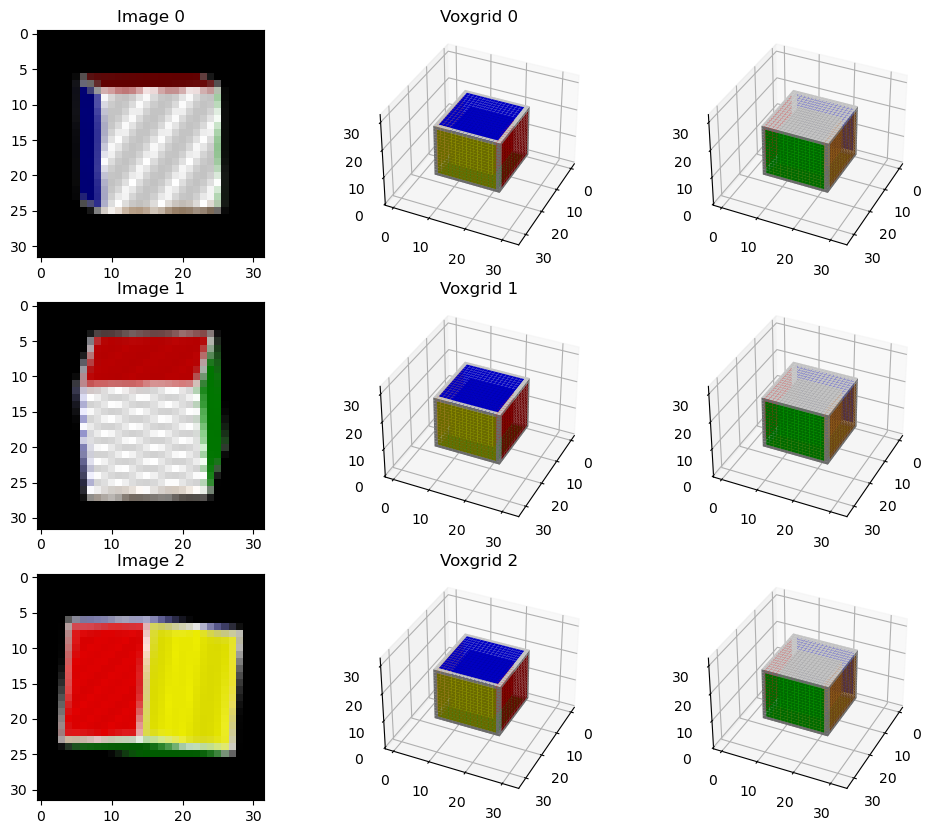

In [3]:
SIDE_LENGTH = 18
IMAGE_SIZE = (32, 32)
SPACE_SIZE = (32, 32, 32)
BATCH_SIZE = 100

train_auto_dataset = datasets.synth.Rubiks(SIDE_LENGTH, SPACE_SIZE, 1000, train=True)
val_auto_dataset = datasets.synth.Rubiks(SIDE_LENGTH, SPACE_SIZE, 100)

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            metaimage.ColourImage(train_auto_dataset[i][0], title=f"Image {i}"),
            voxgrid.VoxGrid(train_auto_dataset[i][1][1], title=f"Voxgrid {i}"),
            voxgrid.VoxGrid(train_auto_dataset[i][1][1], title=f"Voxgrid rotated {i}").rotated(np.pi, np.pi/2),
        ]
        for i in range(3)
    ],
    figsize=(12, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [10]:
LATENT_SIZE = 4
BASE_CHANNELS = 16
DISCRIMINATOR_CHANNELS = 8
FOREGROUND_CHANNELS = 4
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.1
GENERATOR_DROPOUT = 0.1

DEVICE = torch.device("cuda:0")

def create_nnets():
    discriminator = torch.nn.Sequential(
        nnet.blocks.conv.BasicConvBlock(
            in_channels=3,
            out_channels=DISCRIMINATOR_CHANNELS,
            kernel_size=7,
            stride=2,
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0]//2, IMAGE_SIZE[1]//2),
            out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 4, 2, 2),
            layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
                stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
                activation=ACTIVATION,
                dropout=DISCRIMINATOR_DROPOUT,
            ),
            total_layers=1,
        ),
        nnet.blocks.conv.ConvToLinear(
            (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 4, 2, 2),
            out_dim=1,
            activation=torch.nn.Sigmoid,
        ),
    )

    voxel_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * SPACE_SIZE[0] // 2, 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.resnet.create_resnet_3d_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
                stochastic_depth_rate=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            total_layers=2,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=4,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
        nnet.modules.VoxGridAlphaAdjust()
    )

    background_generator = torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(FOREGROUND_CHANNELS * SPACE_SIZE[0]*2, 1, 1),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(FOREGROUND_CHANNELS * SPACE_SIZE[0]*2, 1, 1),
            out_shape=(FOREGROUND_CHANNELS, SPACE_SIZE[0]*2, SPACE_SIZE[1]*2),
            layer_factory=nnet.blocks.conv.create_basic_conv_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        # nnet.blocks.conv.BasicConvBlock(
        #     in_channels=FOREGROUND_CHANNELS,
        #     out_channels=FOREGROUND_CHANNELS,
        #     activation=ACTIVATION,
        #     kernel_size=5,
        # ),
        nnet.blocks.conv.BasicConvBlock(
            in_channels=FOREGROUND_CHANNELS,
            out_channels=3,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        )
    )

    mask_generator = nnet.generators.MaskGenerator(
        model_gen = voxel_generator,
        device = DEVICE,
        background_gen=background_generator,
    )

    return voxel_generator, mask_generator, discriminator

vox_gen_0_noise, mask_gen_0_noise, discriminator_0_noise = create_nnets()

gan_trainer_0_noise = nnet.training.GANTrainer(
    mask_gen_0_noise,
    discriminator_0_noise,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

model_path = "models/rubiks_gan"
bookmark_interval = 25

In [11]:
gan_trainer_0_noise.train(
    train_auto_loader,
    val_auto_loader,
    250,
    path=model_path,
    noise=0.15,
    gen_train_thresh=1.5,
    dis_train_thresh=1.25,
    device=DEVICE,
    bookmark_every=bookmark_interval,
)

Epoch 250/250 | val loss (gen/dis): 0.9917/12.7484 | train loss: 1.35(250)/0.74(96): 100%|██████████| 250/250 [14:24<00:00,  3.46s/it]


Model models/rubiks_gan_150.pt is loaded from epoch 150 , loss 1.0710
Model models/rubiks_gan_175.pt is loaded from epoch 175 , loss 1.2912
Model models/rubiks_gan_200.pt is loaded from epoch 200 , loss 1.1310
Model models/rubiks_gan_225.pt is loaded from epoch 225 , loss 1.0288
Model models/rubiks_gan_250.pt is loaded from epoch 250 , loss 0.9917


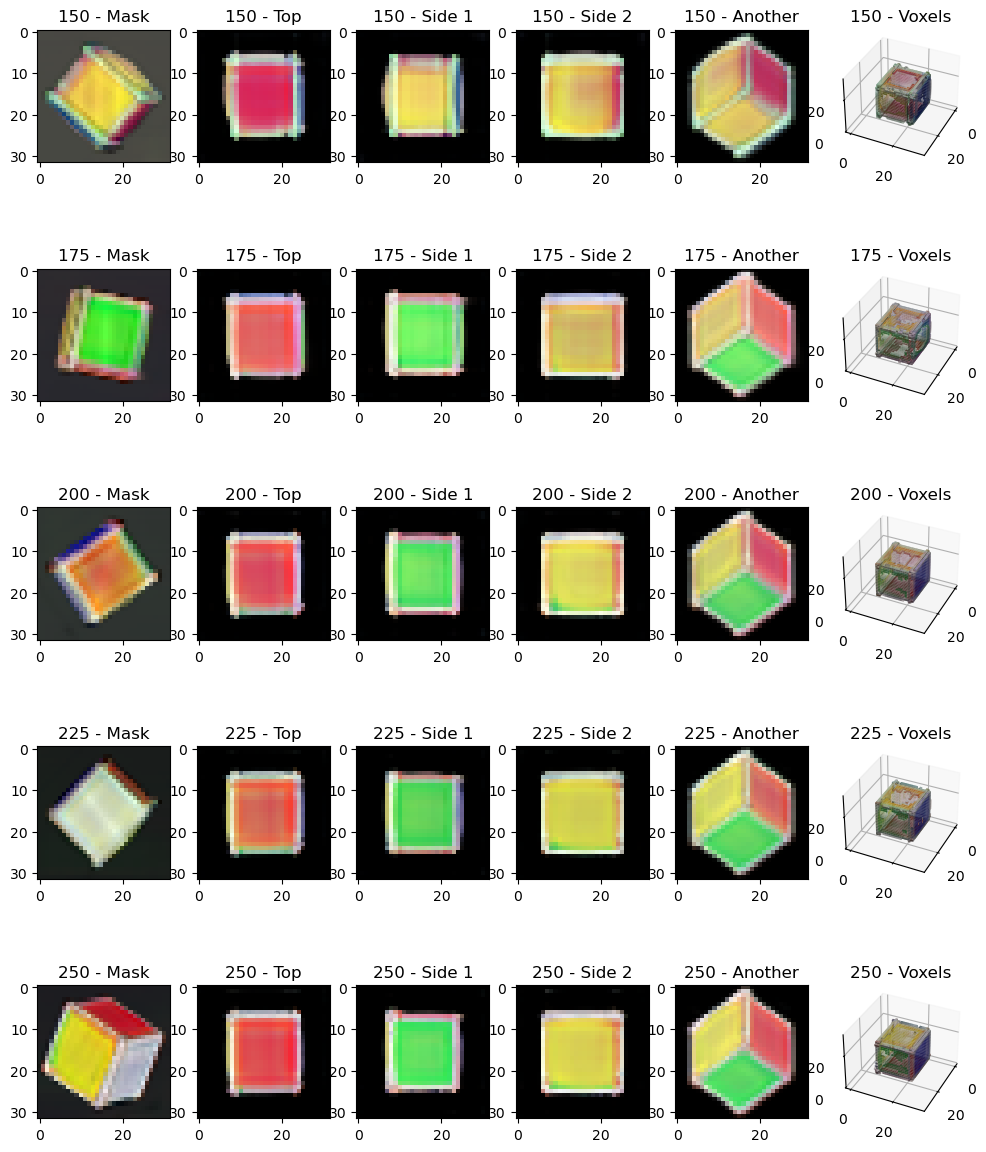

In [12]:
START_MODEL = 150
END_MODEL = 250

models = list(range(START_MODEL, END_MODEL + 1, bookmark_interval))

mask_gen_0_noise.eval()
mask_gen_0_noise.to(DEVICE)

N_MODELS = (END_MODEL - START_MODEL) // bookmark_interval + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for model_n in models:
    gan_trainer_0_noise.load_state(f"{model_path}_{model_n}.pt")

    mask = metaimage.ColourImage(
        mask_gen_0_noise(gen_input)[0], title=f"{model_n} - Mask"
    )
    voxels = voxgrid.VoxGrid(
        vox_gen_0_noise(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_image()),
            (f"{model_n} - Side 1", voxels.rotated(y_angle=np.pi / 2).create_image()),
            (f"{model_n} - Side 2", voxels.rotated(z_angle=np.pi / 2).create_image()),
            (f"{model_n} - Another", voxels.rotated(z_angle=np.pi / 4, y_angle=np.pi/4).create_image()),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/rubiks_gan_250.pt is loaded from epoch 250 , loss 0.9917


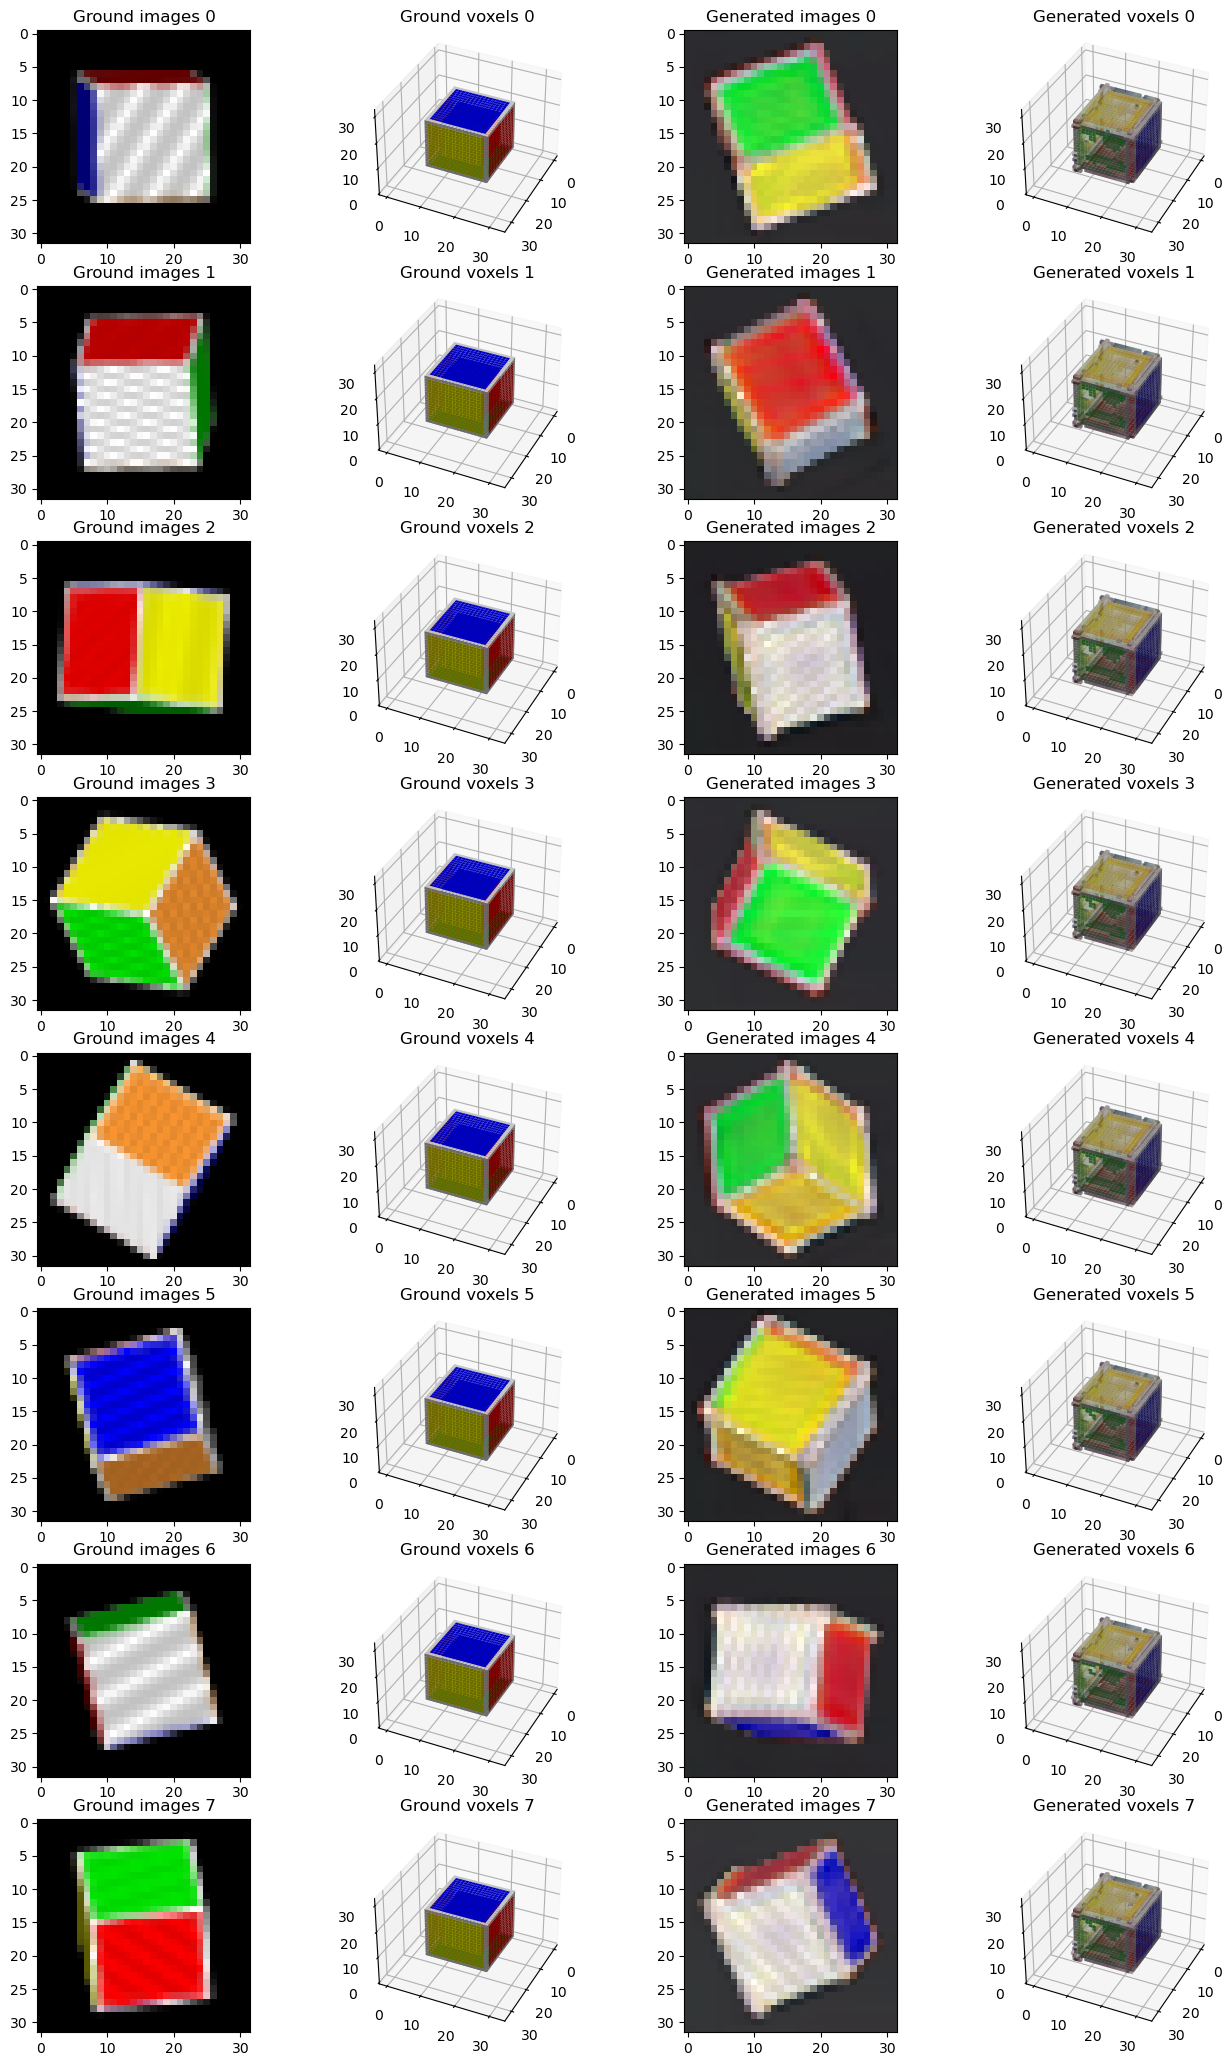

In [17]:
MODEL = 250

gan_trainer_0_noise.load_state(f"{model_path}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(8, LATENT_SIZE))).cuda()

masks = mask_gen_0_noise(gen_input)[:8]
voxels = vox_gen_0_noise(gen_input)[:8]

plot_grid = []

for i in range(8):
    cur_voxels = voxgrid.VoxGrid(voxels[i], title=f"Generated voxels {i}")
    rot_voxels = cur_voxels.rotated(x_angle=np.pi, y_angle=np.pi/2)
    cur_mask = metaimage.ColourImage(masks[i], title=f"Generated images {i}")
    ground_mask, ground_voxels = train_auto_dataset[i][1]
    ground_mask = metaimage.ColourImage(ground_mask, title=f"Ground images {i}")
    ground_voxels = voxgrid.VoxGrid(
        ground_voxels, title=f"Ground voxels {i}"
    )
    groud_rot_voxels = ground_voxels.rotated(x_angle=np.pi, y_angle=np.pi/2)

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(16, 3.25*8))
display.show()